# Esper tutorial

This will walk you through a few of the APIs for accessing, visualizing, and processing data in the Esper environment.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Esper-tutorial" data-toc-modified-id="Esper-tutorial-1">Esper tutorial</a></span><ul class="toc-item"><li><span><a href="#Django-ORM-examples" data-toc-modified-id="Django-ORM-examples-1.1">Django ORM examples</a></span></li><li><span><a href="#Visualizing-video" data-toc-modified-id="Visualizing-video-1.2">Visualizing video</a></span></li><li><span><a href="#Querying-captions" data-toc-modified-id="Querying-captions-1.3">Querying captions</a></span></li><li><span><a href="#Extracting-audiovisual-data" data-toc-modified-id="Extracting-audiovisual-data-1.4">Extracting audiovisual data</a></span></li></ul></li></ul></div>

In [1]:
import esper.prelude
from query.models import Video, Face
from esper.widget import esper_widget, qs_to_result, simple_result
from esper.captions import phrase_search

Loading the document list and lexicon
Matched 197335 documents to videos
0 documents have no videos
17550 videos have no documents


## Django ORM examples

We use Django to structure the code base, and we use its ORM to structure the data base. For example, we have a Video table that you can query using their ORM interface. In our dataset, each video is a 1-3 hour segment.

In [2]:
Video.objects.all()[0]

Video(id: 62048, path: tvnews/videos/CNNW_20110513_150000_CNN_Newsroom.mp4, num_frames: 215794, fps: 29.97, width: 640, height: 480, has_captions: False, time: 2011-05-13 15:00:00, commercials_labeled: False, srt_extension: word, threeyears_dataset: False)

Face bounding boxes are stored in the Face table. To see more tables, look at `app/query/models.py`

In [3]:
Face.objects.all()[0]

Face(id: 250544339, bbox_x1: 0.672266960144043, bbox_x2: 0.77619069814682, bbox_y1: 0.246682971715927, bbox_y2: 0.438885480165482, background: False, is_host: False, blurriness: None, probability: 1.0)

The Django ORM converts Python-ish queries into SQL, e.g. here counting # of faces on CNN
(warning: this will take a while)

In [ ]:
Face.objects.filter(frame__video__channel__name='CNN').count()

## Visualizing video
To visualize results, we have a Jupyter-embedded widget that takes a data structure describing
a visualization. Here, we have the qs_to_result helper function that converts a Django QuerySet
into such a "reuslt" structure.

In [4]:
qs_to_result(Face.objects.all(), limit=2)

{'count': 0,
 'result': [{'elements': [{'min_frame': 126374,
     'objects': [{'background': False,
       'bbox_x1': 0.331790447235107,
       'bbox_x2': 0.408328801393509,
       'bbox_y1': 0.251164436340332,
       'bbox_y2': 0.395187467336655,
       'id': 250544340,
       'type': 'bbox'},
      {'background': False,
       'bbox_x1': 0.672266960144043,
       'bbox_x2': 0.77619069814682,
       'bbox_y1': 0.246682971715927,
       'bbox_y2': 0.438885480165482,
       'id': 250544339,
       'type': 'bbox'}],
     'video': 145}],
   'label': '',
   'type': 'flat'}],
 'type': 'Face'}

We can use this structure with the esper_widget function.
Note that we use a number of keybindings to interact with the Esper widget. If you go to the 
main page at http://35.185.221.100, you can see extended help. You will have to click the
"disable jupyter keyboard" button while using the widget, since otherwise the keys conflict
with Jupyter's (sadly).

In [5]:
widget = esper_widget(qs_to_result(Face.objects.all()))
widget

VGridWidget(jsglobals={'schema': [['Identity', ['id', 'name']], ['CanonicalShow', ['id', 'name', 'is_recurring…

If you select clips in the widget by clicking "s" on the clip, then the indices of the selected clips
are available in Python here. This is useful for doing labeling tasks inside a Jupyter notebook.

In [ ]:
widget.selected

## Querying captions
We have Python libraries for searching through our captions. This one returns all instances of a particular
phrase in the captions. The source files are located at `app/data/subs/orig`

In [6]:
generator = phrase_search('MERRY CHRISTMAS')
phrase_instance = next(generator)
phrase_instance

Document(id=62236, postings=[Posting(start=6702.4091796875, end=6703.169921875, idx=16834, len=2)])

Show the video clip corresponding to the phrase. Press "p" to play.

In [7]:
esper_widget(simple_result([{
    'video': phrase_instance.id,
    'min_time': phrase_instance.postings[0].start,
    'max_time': phrase_instance.postings[0].end
}]))

VGridWidget(jsglobals={'schema': [['Identity', ['id', 'name']], ['CanonicalShow', ['id', 'name', 'is_recurring…

## Extracting audiovisual data
The video files are too big to be stored on any machine (unlike the captions). They're on Google Cloud Storage, at `gs://esper/tvnews/videos`. However, we have a number of APIs for accessing raw data. For example, we use the [`scannertools`](https://github.com/scanner-research/scannertools) API to access individual frames of a video.

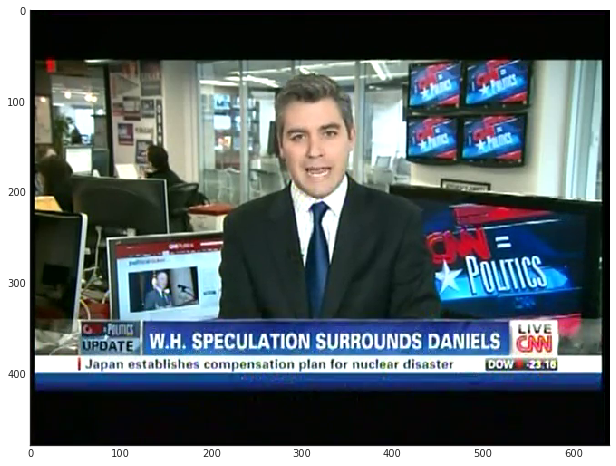

In [9]:
import matplotlib.pyplot as plt
video = Video.objects.all()[0]
plt.imshow(video.for_scannertools().frame(100))

You can also use ffmpeg to download segments of video or audio.

In [10]:
print(video.download(ext='aac', segment=(0, 10)))  # audio from time 0s to 10s
print(video.download(ext='mp4', segment=(10, 20))) # video+audio from time 10s to 20s

/tmp/tmpkmjo0qh2.aac
/tmp/tmpj7qfy210.mp4
